# Importing relevant modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import sklearn.metrics as metrics
from mpl_toolkits.mplot3d import Axes3D
     

# Loading dataset

In [3]:
df = pd.read_csv('saveecobot_4230.csv')
df = df.drop(['value_text'], axis=1)
df.head()

,device_id,phenomenon,value,logged_at
0,4230,aqi,65.0,2020-08-11 23:00:00
1,4230,pm25,18.6,2020-08-11 23:00:00
2,4230,temperature,19.0,2020-08-11 23:00:00
3,4230,humidity,88.0,2020-08-11 23:00:00
4,4230,pressure_pa,101500.0,2020-08-11 23:00:00


# Exploration Data Analysis

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124610 entries, 0 to 124609
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   device_id   124610 non-null  int64  
 1   phenomenon  124610 non-null  object 
 2   value       124610 non-null  float64
 3   logged_at   124610 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 3.8+ MB


In [5]:
df.describe()

,device_id,value
count,124610.0,124610.000000
mean,4230.0,20351.991925
std,0.0,40626.486865
min,4230.0,-21.000000
25%,4230.0,13.000000
50%,4230.0,47.000000
75%,4230.0,93.000000
max,4230.0,104800.000000


## Cheking for missing values

In [6]:
df.isnull().sum()

device_id     0
phenomenon    0
value         0
logged_at     0
dtype: int64

In [7]:
(df['value'] == 0).sum()

2397

In [8]:
print(f'Percentage of "0" entries: {round((df["value"] == 0).sum()/len(df) * 100, 3)} %')

Percentage of "0" entries: 1.924 %


Since the amount of such values are insignificant it's save to delete them.

In [9]:
df = df[df['value'] != 0]

## Transform dates

In [10]:
df['logged_at'] = pd.to_datetime(df['logged_at'])
df

,device_id,phenomenon,value,logged_at
0,4230,aqi,65.0,2020-08-11 23:00:00
1,4230,pm25,18.6,2020-08-11 23:00:00
2,4230,temperature,19.0,2020-08-11 23:00:00
3,4230,humidity,88.0,2020-08-11 23:00:00
4,4230,pressure_pa,101500.0,2020-08-11 23:00:00
...,...,...,...,...
124605,4230,aqi,12.0,2023-09-05 17:00:00
124606,4230,pm25,3.0,2023-09-05 17:00:00
124607,4230,temperature,24.0,2023-09-05 17:00:00
124608,4230,humidity,43.0,2023-09-05 17:00:00


## Transform pressure values

Since the values of pressure_pa are usually higher than 1000, values for this column should be normalized.

In [11]:
df.loc[df['phenomenon'] == 'pressure_pa', 'value'] /= 1000

In [12]:
df['phenomenon'] = df['phenomenon'].replace({'pressure_pa': 'pressure_kpa'})

Too analize these plots futher, data needs to be group by phenomenon and time.

In [13]:
df['logged_at'] = pd.to_datetime(df['logged_at'])
df['hour'] = df['logged_at'].dt.hour
df['month'] = df['logged_at'].dt.month

In [14]:
phenomenons = list(df['phenomenon'].unique())
colors = ['lightcoral', 'palegreen', 'lightblue', 'plum', 'lightpink']

In [15]:
num_categories = len(phenomenons)
num_cols = 2
num_rows = (num_categories + num_cols - 1) // num_cols
confidence_interval = 0.95

### Relationship between phenomenons and months

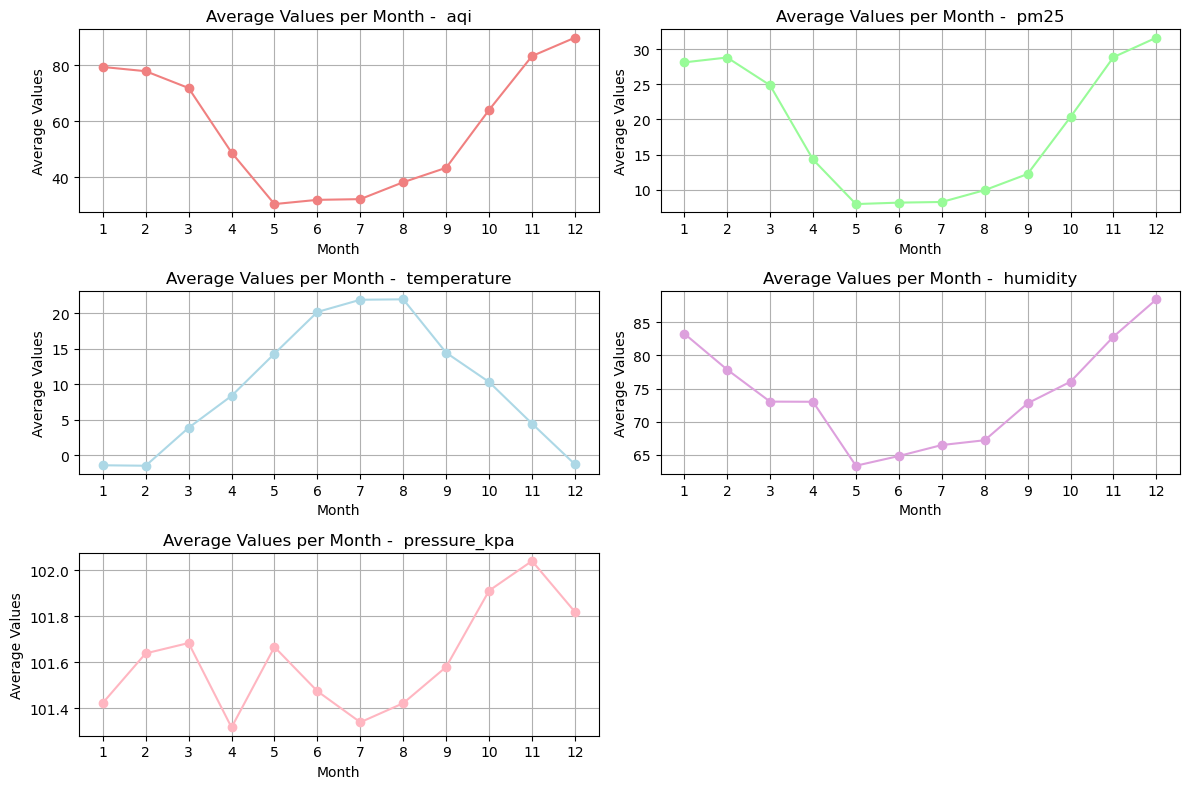

In [16]:

average_values = df.groupby(['phenomenon', 'month'])['value'].mean().reset_index()
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

for i, phenomenon_category in enumerate(phenomenons):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]
    subset_df = average_values[average_values['phenomenon'] == phenomenon_category]
    ax.plot(subset_df['month'], subset_df['value'], marker='o', color=colors[i % len(colors)])
    ax.set_xlabel('Month')
    ax.set_ylabel('Average Values')
    ax.set_title(f'Average Values per Month -  {phenomenon_category}')
    ax.grid(True)
    ax.set_xticks(range(1, 13))

for i in range(num_categories, num_cols * num_rows):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

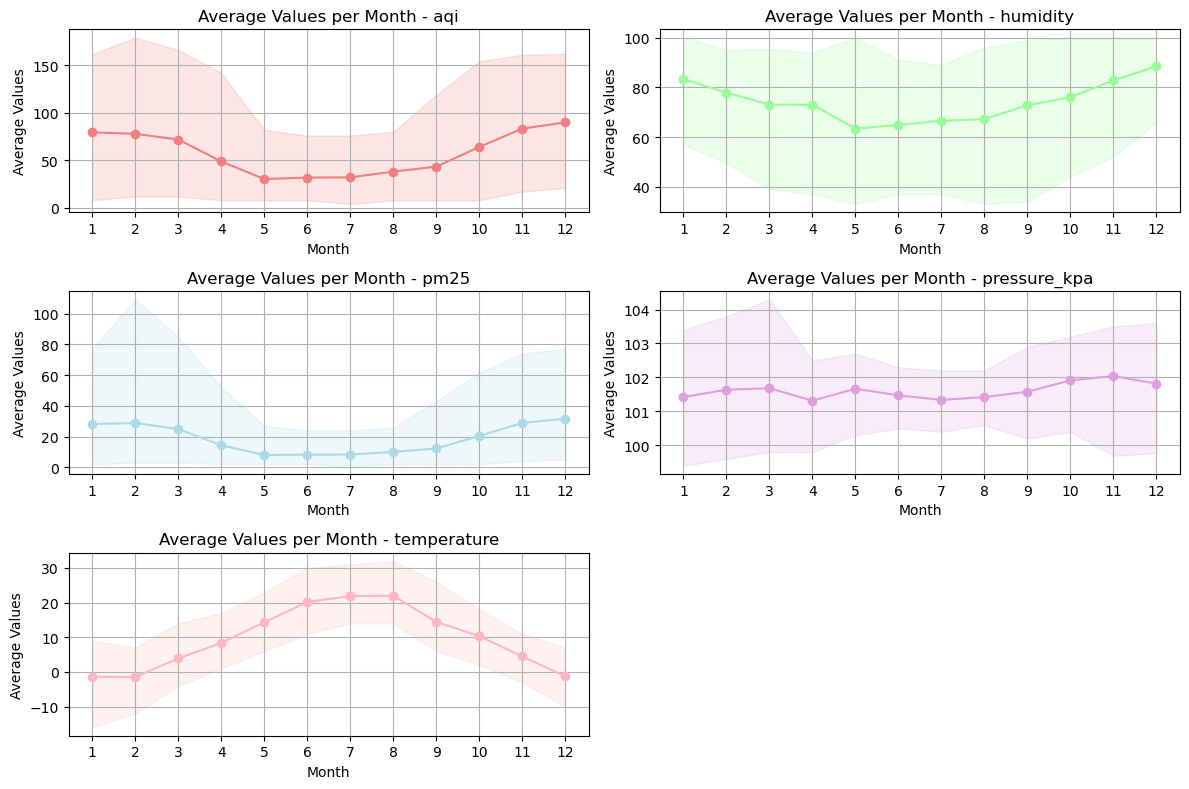

In [17]:


average_values = df.groupby(['phenomenon', 'month'])['value'].agg([np.mean, lambda x: np.percentile(x, q=((1-confidence_interval)*100)/2), lambda x: np.percentile(x, q=100-((1-confidence_interval)*100)/2)]).reset_index()
average_values.columns = ['phenomenon', 'month', 'mean', 'lower_ci', 'upper_ci']


fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

for i, phenomenon_category in enumerate(average_values['phenomenon'].unique()):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]
    
    subset_df = average_values[average_values['phenomenon'] == phenomenon_category]

    ax.plot(subset_df['month'], subset_df['mean'], marker='o', color=colors[i])
    ax.fill_between(subset_df['month'], subset_df['lower_ci'], subset_df['upper_ci'], color=colors[i], alpha=0.2)
    
    ax.set_xlabel('Month')
    ax.set_ylabel('Average Values')
    ax.set_title(f'Average Values per Month - {phenomenon_category}')
    ax.grid(True)
    ax.set_xticks(range(1, 13))

for i in range(num_categories, num_cols * num_rows):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

### Relationship between phenomenons and hours

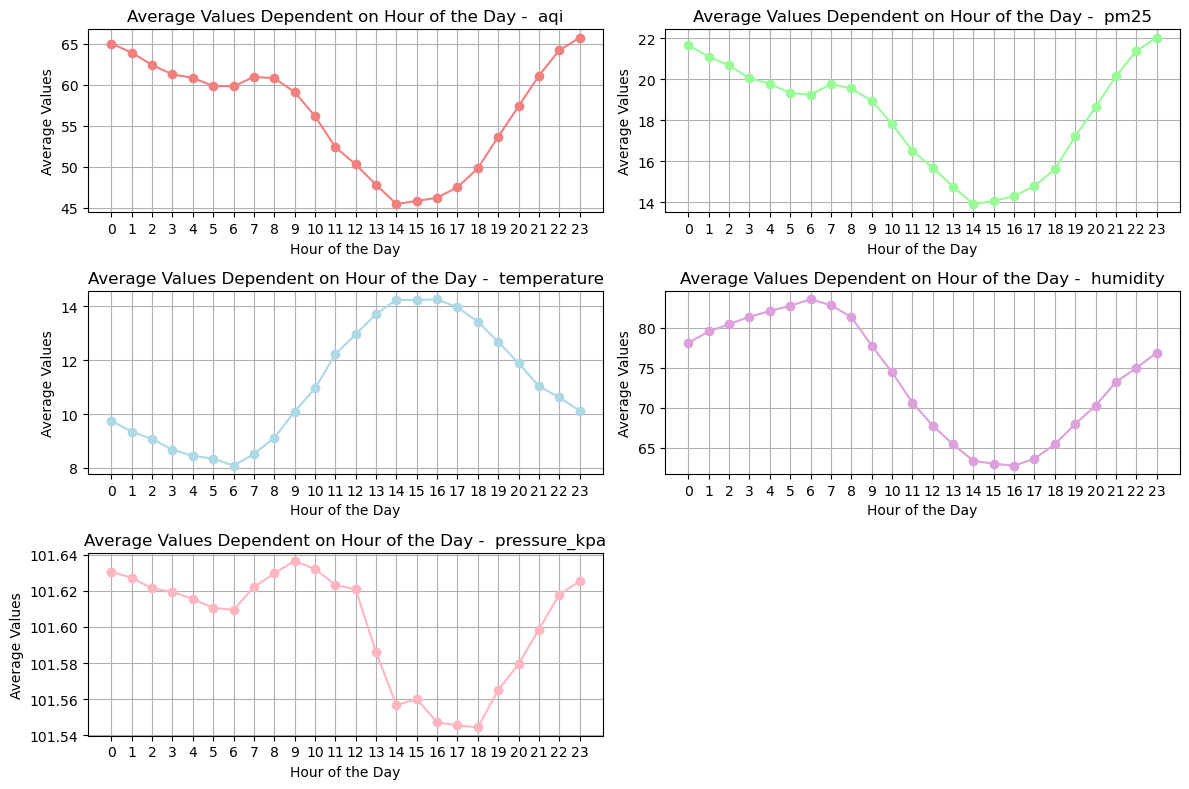

In [18]:
average_values = df.groupby(['phenomenon', 'hour'])['value'].mean().reset_index()
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

for i, phenomenon_category in enumerate(phenomenons):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]

    subset_df = average_values[average_values['phenomenon'] == phenomenon_category]
    ax.plot(subset_df['hour'], subset_df['value'], marker='o', color=colors[i % len(colors)])
    ax.set_xlabel('Hour of the Day')
    ax.set_ylabel('Average Values')
    ax.set_title(f'Average Values Dependent on Hour of the Day -  {phenomenon_category}')
    ax.grid(True)
    ax.set_xticks(range(24))

for i in range(num_categories, num_cols * num_rows):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

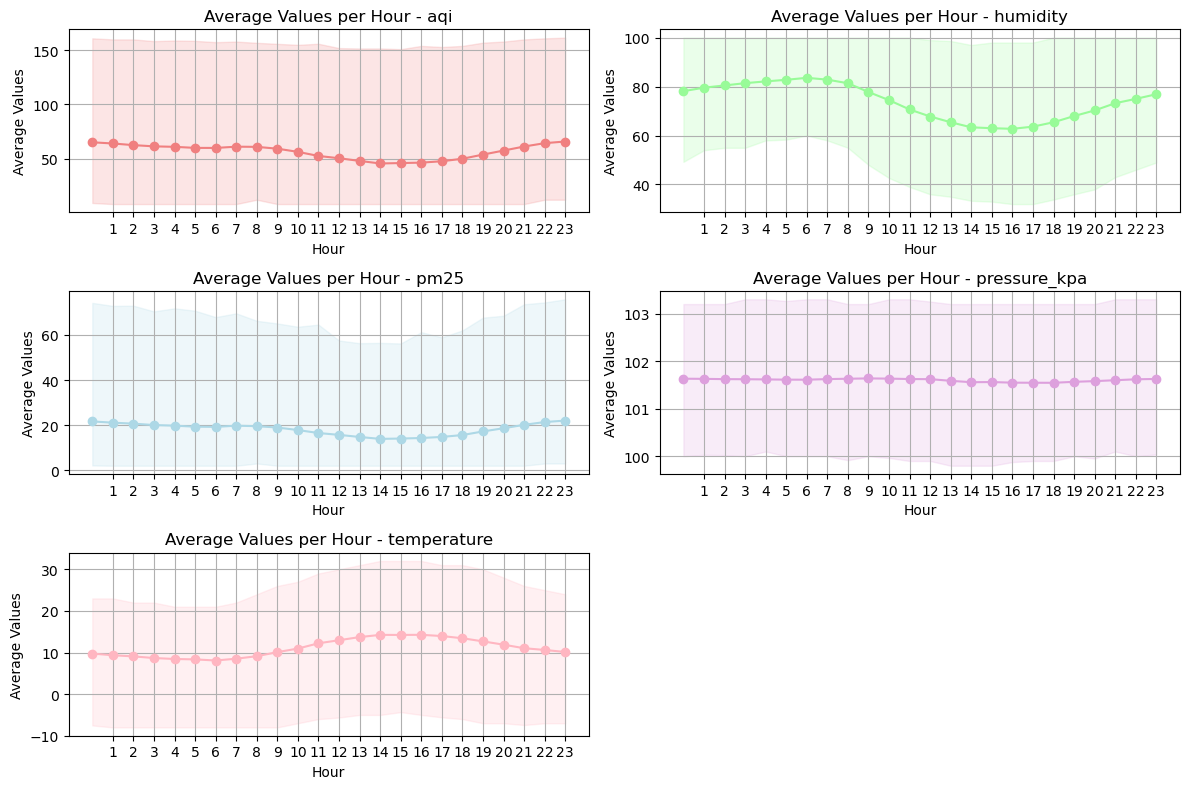

In [19]:


average_values = df.groupby(['phenomenon', 'hour'])['value'].agg([np.mean, lambda x: np.percentile(x, q=((1-confidence_interval)*100)/2), lambda x: np.percentile(x, q=100-((1-confidence_interval)*100)/2)]).reset_index()
average_values.columns = ['phenomenon', 'hour', 'mean', 'lower_ci', 'upper_ci']


fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

for i, phenomenon_category in enumerate(average_values['phenomenon'].unique()):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]
    
    subset_df = average_values[average_values['phenomenon'] == phenomenon_category]

    ax.plot(subset_df['hour'], subset_df['mean'], marker='o', color=colors[i])
    ax.fill_between(subset_df['hour'], subset_df['lower_ci'], subset_df['upper_ci'], color=colors[i], alpha=0.2)
    
    ax.set_xlabel('Hour')
    ax.set_ylabel('Average Values')
    ax.set_title(f'Average Values per Hour - {phenomenon_category}')
    ax.grid(True)
    ax.set_xticks(range(1, 24))

for i in range(num_categories, num_cols * num_rows):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

# Regression analysis

## Finding correlation

In [20]:
entry_counts = df['phenomenon'].value_counts()
entry_counts

humidity        24922
pressure_kpa    24922
pm25            24907
aqi             24906
temperature     22556
Name: phenomenon, dtype: int64

In [21]:
number_of_entries_list = entry_counts.tolist()
print(f'{(max(number_of_entries_list) - min(number_of_entries_list)) / max(number_of_entries_list) * 100} %')

9.49362009469545 %


For making correlation matrix values for each phenomenon category nedd to be extracted.

In [22]:
grouped_values = df.groupby('phenomenon')['value'].apply(list)
phenomenon_values = {}

for i in range(len(grouped_values)):
    phenomenon_values[phenomenons[i]] = grouped_values[i]


for i in phenomenon_values:
    if len(phenomenon_values[i]) > min(number_of_entries_list):
        phenomenon_values[i] = phenomenon_values[i][:min(number_of_entries_list)]


In [23]:
phenomenon_values = pd.DataFrame(phenomenon_values)

In [24]:
phenomenon_values

,aqi,pm25,temperature,humidity,pressure_kpa
0,65.0,88.0,18.6,101.5,19.0
1,66.0,88.0,19.1,101.5,19.0
2,69.0,88.0,20.5,101.5,19.0
3,54.0,72.0,13.4,101.5,18.0
4,39.0,77.0,9.5,101.5,18.0
...,...,...,...,...,...
22551,17.0,44.0,6.0,101.7,25.0
22552,12.0,43.0,4.0,101.7,24.0
22553,12.0,53.0,3.0,101.7,25.0
22554,12.0,56.0,3.0,101.8,24.0


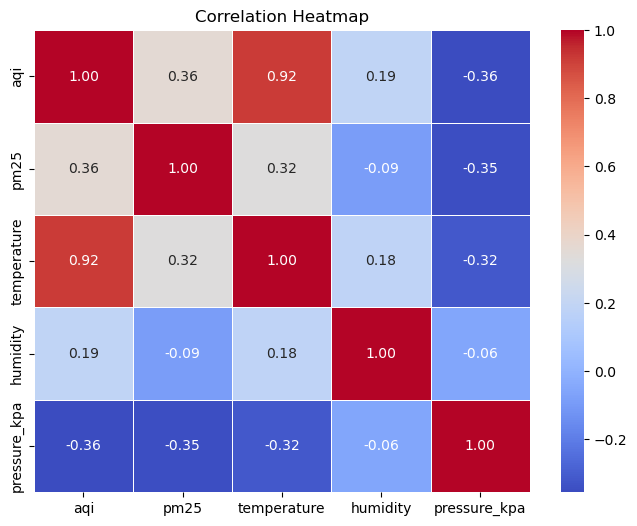

In [25]:
plt.figure(figsize=(8, 6))
sns.heatmap(phenomenon_values.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

## Making timeseries

In [26]:
aqi_df = df[df['phenomenon'] == 'aqi']
aqi_df = aqi_df.sort_values('hour')

In [27]:
aqi_df

,device_id,phenomenon,value,logged_at,hour,month
10760,4230,aqi,160.0,2020-11-14 00:00:00,0,11
63720,4230,aqi,72.0,2022-03-08 00:00:00,0,3
45775,4230,aqi,45.0,2021-09-29 00:00:00,0,9
93390,4230,aqi,61.0,2022-12-04 00:00:00,0,12
63835,4230,aqi,21.0,2022-03-09 00:00:00,0,3
...,...,...,...,...,...,...
60190,4230,aqi,68.0,2022-02-05 23:00:00,23,2
35935,4230,aqi,49.0,2021-06-29 23:00:00,23,6
60080,4230,aqi,233.0,2022-02-04 23:00:00,23,2
36405,4230,aqi,29.0,2021-07-03 23:00:00,23,7


In [28]:
ts = aqi_df[['logged_at', 'value']].set_index('logged_at')

In [29]:
ts

,value
logged_at,
2020-11-14 00:00:00,160.0
2022-03-08 00:00:00,72.0
2021-09-29 00:00:00,45.0
2022-12-04 00:00:00,61.0
2022-03-09 00:00:00,21.0
...,...
2022-02-05 23:00:00,68.0
2021-06-29 23:00:00,49.0
2022-02-04 23:00:00,233.0


In [30]:
hourly_data = ts['value'].resample('H').mean()
# Fill missing values with interpolation (you can choose other methods)
hourly_data = hourly_data.interpolate(method='linear')

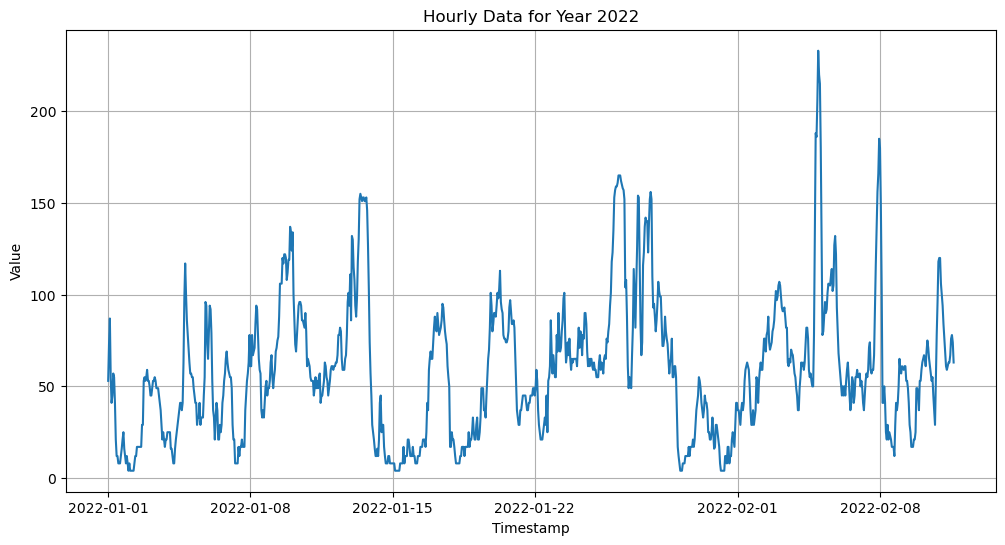

In [31]:
hourly_data.index = pd.to_datetime(hourly_data.index)

# Filter data for the year 2022
hourly_data_2022 = hourly_data['2022']
hourly_data_2023 = hourly_data['2023']

# Plot the data for 2022
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(hourly_data_2022[:1000])
plt.title('Hourly Data for Year 2022')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.grid(True)
plt.show()

<AxesSubplot:ylabel='Frequency'>

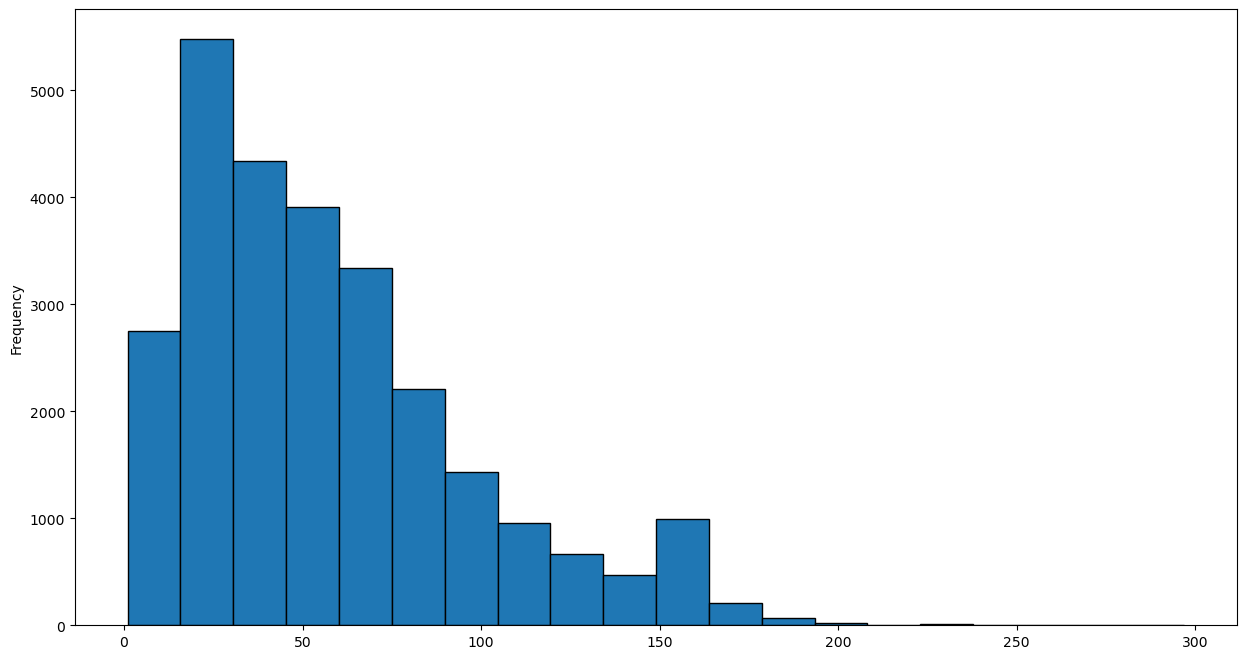

In [32]:
hourly_data.plot.hist(figsize=(15,8), bins=20, edgecolor='black')

## Decomposing timeseries

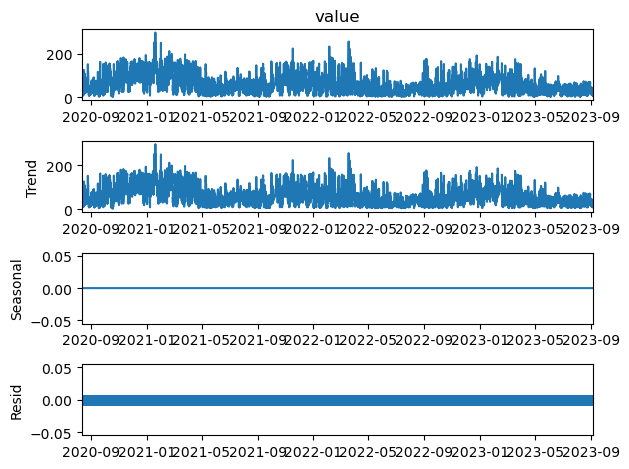

In [33]:
from random import randrange
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose
series = hourly_data
result = seasonal_decompose(series, model='additive', period=1)
result.plot()
pyplot.show()

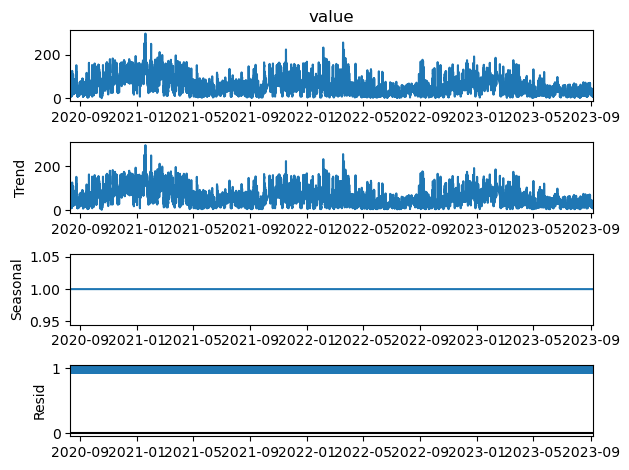

In [34]:
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose
series = hourly_data
result = seasonal_decompose(series, model='multiplicative', period=1)
result.plot()
pyplot.show()

## ARIMA

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Assuming you have hourly_data as your time series

# Filter data for the years 2020, 2021, and 2022 for training
train_data = hourly_data['2020':'2022']

# Filter data for the year 2023 for testing
test_data = hourly_data['2023']

# Define the ARIMA order (p, d, q)
p, d, q = 3, 0, 2  # Example values, adjust as needed

# Fit the ARIMA model to the training data
model = ARIMA(train_data, order=(p, d, q))
model_fit = model.fit()

# Forecast future values (2023)
forecast_steps = len(test_data)

# Get the forecast and confidence intervals
forecast_results = model_fit.predict(start=len(train_data), end=len(train_data)+forecast_steps-1, typ='levels', dynamic=True)

# Extract forecasted values and confidence intervals
forecast_values = forecast_results.predicted_mean
confidence_intervals = forecast_results.conf_int()

# Create a DataFrame for the forecasted values with a datetime index
forecast_index = pd.date_range(start='2023-01-01 00:00:00', periods=forecast_steps, freq='H')
forecast_df = pd.DataFrame({'forecasted_value': forecast_values, 
                            'lower_confidence': confidence_intervals.iloc[:, 0],
                            'upper_confidence': confidence_intervals.iloc[:, 1]}, 
                           index=forecast_index)

# Plot the actual data, forecasted values, and confidence intervals
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Training Data', color='blue')
plt.plot(test_data, label='Testing Data', color='green')
plt.plot(forecast_df.index, forecast_df['forecasted_value'], color='red', label='Forecasted Values')
plt.fill_between(forecast_df.index, forecast_df['lower_confidence'], forecast_df['upper_confidence'], color='pink', alpha=0.3, label='95% Confidence Interval')
plt.title('ARIMA Forecast with Confidence Interval')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.show()


/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AttributeError: 'Series' object has no attribute 'predicted_mean'

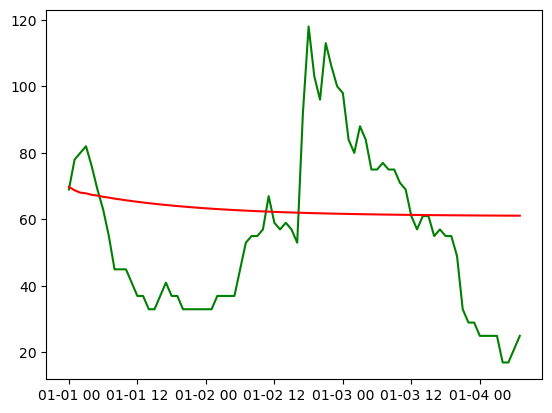

In [ ]:
plt.plot(test_data[:80], label='Testing Data', color='green')
plt.plot(forecast_df.index[:80], forecast_df['forecasted_value'][:80], color='red', label='Forecasted Values')

In [ ]:
forecast_df

,forecasted_value,lower_confidence,upper_confidence
2023-01-01 00:00:00,70.696483,51.058554,90.334412
2023-01-01 01:00:00,71.168145,40.918970,101.417320
2023-01-01 02:00:00,71.204744,33.868755,108.540733
2023-01-01 03:00:00,71.596404,28.925033,114.267775
2023-01-01 04:00:00,72.768711,26.032653,119.504769
...,...,...,...
2023-09-05 13:00:00,60.973532,-19.860258,141.807322
2023-09-05 14:00:00,60.973532,-19.860258,141.807322
2023-09-05 15:00:00,60.973532,-19.860258,141.807322
2023-09-05 16:00:00,60.973532,-19.860258,141.807322


/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


Text(0.5, 1.0, 'Partial Autocorrelation Function (PACF)')

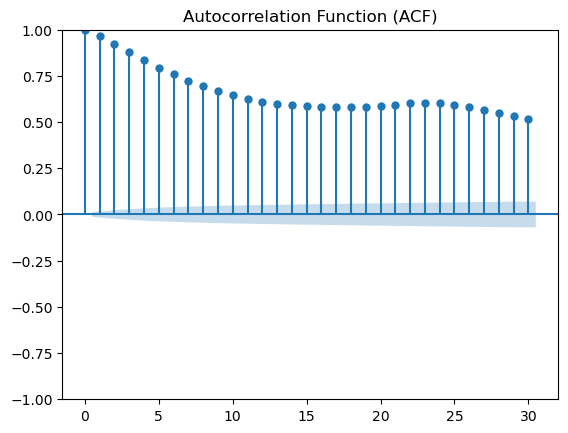

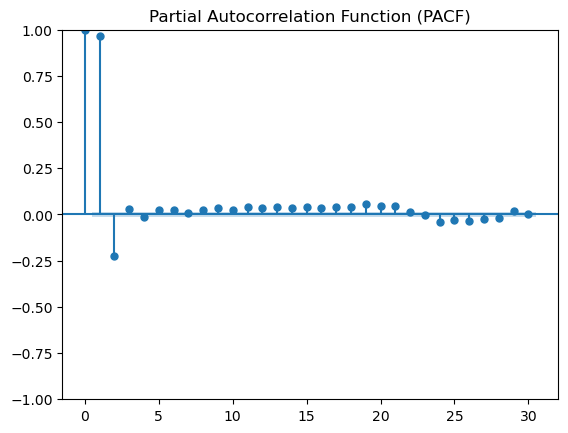

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_plot = plot_acf(train_data, lags=30)
plt.title('Autocorrelation Function (ACF)')
pacf_plot = plot_pacf(train_data, lags=30)
plt.title('Partial Autocorrelation Function (PACF)')

In [ ]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                20929
Model:                 ARIMA(3, 0, 2)   Log Likelihood              -78168.063
Date:                Sat, 09 Sep 2023   AIC                         156350.125
Time:                        13:38:17   BIC                         156405.767
Sample:                    08-11-2020   HQIC                        156368.290
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         60.9729      2.164     28.173      0.000      56.731      65.215
ar.L1          0.3708      0.278      1.333      0.183      -0.174       0.916
ar.L2          0.6423      0.280      2.291      0.0